In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle

In [119]:
def undistort_image(img):
	# read calibration matrix and distortion coefficeint
	dist_pickle = pickle.load( open("camera_cal/calibration_pickle.p", "rb"))
	mtx = dist_pickle["mtx"]
	dist = dist_pickle["dist"]
	img_undistort = cv2.undistort(img, mtx, dist, None, mtx)

	return img_undistort

In [138]:
def thresholded_binary(undistorted_img):
    """
    :param undistorted_img:
        Source image for thresholding that has already been undistorted.
    
    :return:
        Returns a colour binary image for visualisation purposes and a
        binary thresholded image for use in lane finding.
    """
    
    # Sobel x gradient
    gray = cv2.cvtColor(undistorted_img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))

    # Threshold x gradient
    #thresh_min = 30
    #thresh_max = 150
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(undistorted_img, cv2.COLOR_RGB2HLS).astype("float")
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_thresh_min = 100
    s_thresh_max = 255
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1    

    # Convert to HSV color space and separate the V channel
    # Note: img is the undistorted image
    hsv = cv2.cvtColor(undistorted_img, cv2.COLOR_RGB2HSV).astype("float")
    v_channel = hsv[:,:,2]
    v_binary = np.zeros_like(v_channel)
    v_thresh_min = 50
    v_thresh_max = 255
    v_binary[(v_channel >= v_thresh_min) & (v_channel <= v_thresh_max)] = 1  
    
    # use bitand to obtian the threshold binary for s channel and v channeel
    s_v_binary = np.zeros_like(s_channel)
    s_v_binary[(s_binary == 1) & (v_binary == 1)] =  1
    
    # Stack each channel to view their individual contributions in green (sxbinary) and blue (s_v_binary) respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack((np.zeros_like(sxbinary), sxbinary, s_v_binary))
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_v_binary == 1) | (sxbinary == 1)] = 1

    # create a mask to filter out pixels inside the shape from src points
    vertices = np.array([[[575+50, 464+50],
                 [730-50, 464+50],
                 [1100-100, 682],
                 [280+100, 682]]], dtype=np.int32 )
    mask = np.ones_like(combined_binary)
    cv2.fillPoly(mask, vertices, 0)
    combined_binary = cv2.bitwise_and(combined_binary, mask)

    return color_binary, combined_binary

In [123]:
def get_src_dest_warp_img(image):

    h,w = image.shape[:2]

    # define source and destination points for transform
    #src = np.float32([(575,464), (730,464), (280,682), (1100,682)])
    src = np.float32([(575,464), (730,464), (230,h), (1150,h)])
    dst = np.float32([(200,0), (w-200,0), (200,h), (w-200,h)])

    return src, dst

In [124]:
def warp_image(img, src, dst):

    h,w = img.shape[:2]
    # use cv2.getPerspectiveTransform() to get M, the transform matrix, and Minv, the inverse
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    return warped, M, Minv

In [127]:
def find_lane_lines(binary_warped):

	# take a histogram along all the columns in the lower half of the image
	histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
	# Create an output image to draw on and  visualize the result, thus stacked into rgb channels
	out_img = np.dstack((binary_warped, binary_warped, binary_warped))

	# Find the peak of the left and right halves of the histogram
	# These will be the starting point for the left and right lines
	midpoint = histogram.shape[0]//2
	leftx_base = np.argmax(histogram[:midpoint])
	rightx_base = np.argmax(histogram[midpoint:]) + midpoint

	# Choose the number of sliding windows
	nwindows = 9
	# Set height of windows
	window_height = binary_warped.shape[0]//nwindows

	# Identify the x and y positions of all nonzero pixels in the image
	nonzero = binary_warped.nonzero()
	nonzeroy = np.array(nonzero[0])
	nonzerox = np.array(nonzero[1])

	# Current positions to be updated for each window
	leftx_current = leftx_base
	rightx_current = rightx_base

	# Set the width of the windows +/- margin
	margin = 100
	# Set minimum number of pixels found to recenter window
	minpix = 50
	# Create empty lists to receive left and right lane pixel indices
	left_lane_inds = []
	right_lane_inds = []

	# Step through the windows one by one
	for window in range(nwindows):
		# Identify window boundaries in x and y (and right and left)
		win_y_low = binary_warped.shape[0] - (window+1)*window_height
		win_y_high = binary_warped.shape[0] - window*window_height
		win_xleft_low = leftx_current - margin
		win_xleft_high = leftx_current + margin
		win_xright_low = rightx_current - margin
		win_xright_high = rightx_current + margin

		# Draw the windows on the visualization image
		cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2)
		cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)

		# Identify the nonzero pixels in x and y within the window
		good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
		good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

		# Append these indices to the lists
		left_lane_inds.append(good_left_inds)
		right_lane_inds.append(good_right_inds)

		# If you found > minpix pixels, recenter next window on their mean position
		if len(good_left_inds) > minpix:
			leftx_current = np.int(np.mean(nonzerox[good_left_inds]))

		if len(good_right_inds) > minpix: 
			rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

	# Concatenate the arrays of indices
	left_lane_inds = np.concatenate(left_lane_inds)
	right_lane_inds = np.concatenate(right_lane_inds)

	# Extract left and right line pixel positions
	leftx = nonzerox[left_lane_inds]
	lefty = nonzeroy[left_lane_inds] 
	rightx = nonzerox[right_lane_inds]
	righty = nonzeroy[right_lane_inds] 

	# Fit a second order polynomial to each
	left_fit = np.polyfit(lefty, leftx, 2)
	right_fit = np.polyfit(righty, rightx, 2)

	# For Visualization
	# Generate x and y values for plotting
	ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
	left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
	right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

	# Measuring Curvature
	# A_left = left_fit[0], B_left = left_fit[1], C_left = left_fit[2]
	# A_right = right_fit[0], B_right = right_fit[1], C_right = right_fit[2]
	# according to equation for radius of curvature 
	y_eval = out_img.shape[0]

	# Define conversions in x and y from pixels space to meters
	ym_per_pix = 30/720 # meters per pixel in y dimension
	xm_per_pix = 3.7/700 # meters per pixel in x dimension

	# Fit new polynomials to x,y in world space
	left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
	right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
	left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
	right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

	# Calculate Lane Deviation from center of lane:
	# First we calculate the intercept points at the bottom of our image, then use those to 
	# calculate the lane deviation of the vehicle (assuming camera is in center of vehicle)
	scene_height = out_img.shape[0] * ym_per_pix
	scene_width = out_img.shape[1] * xm_per_pix
	    
	left_intercept = left_fit_cr[0] * scene_height ** 2 + left_fit_cr[1] * scene_height + left_fit_cr[2]
	right_intercept = right_fit_cr[0] * scene_height ** 2 + right_fit_cr[1] * scene_height + right_fit_cr[2]
	calculated_center = (left_intercept + right_intercept) / 2.0
	    
	lane_deviation = (calculated_center - scene_width / 2.0)

	return left_fitx, right_fitx, ploty, left_curverad, right_curverad, lane_deviation

In [128]:
## unwarp detected lane back to original image
def draw_lanes_on_image(binary_warped, undistorted_img, Minv, left_fitx, right_fitx, ploty, left_radius, right_radius, lane_deviation):
    """
    Draw the found lane lines onto a binary warped image, then unwarp
    and overlay on the original image.
    
    binary_warped
    Minv
    left_fitx
    right_fitx
    ploty
    """
    
    # Create a blank image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undistorted_img.shape[1], undistorted_img.shape[0])) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted_img, 1, newwarp, 0.3, 0)
    
    curvature_text = "Curvature: Left = " + str(np.round(left_radius, 2)) + " m, Right = " + str(np.round(right_radius, 2)) + " m"
    font = cv2.FONT_HERSHEY_COMPLEX    
    cv2.putText(result, curvature_text, (30, 60), font, 1, (0,255,0), 2)
    deviation_text = "Lane deviation from center = {:.2f} m".format(lane_deviation) 
    font = cv2.FONT_HERSHEY_COMPLEX    
    cv2.putText(result, deviation_text, (30, 90), font, 1, (0,255,0), 2)
        
    return result

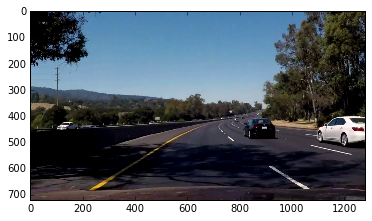

In [9]:
## debug
# Run on a test image
img = cv2.imread("problem_imgs/frame_001046.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

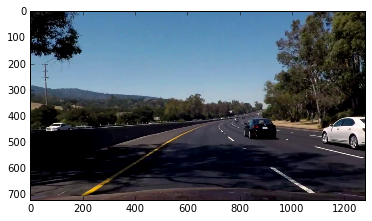

In [11]:
undistorted = undistort_image(img)
plt.imshow(undistorted)
plt.show()

In [ ]:
src, dst = get_src_dest_warp_img(img)


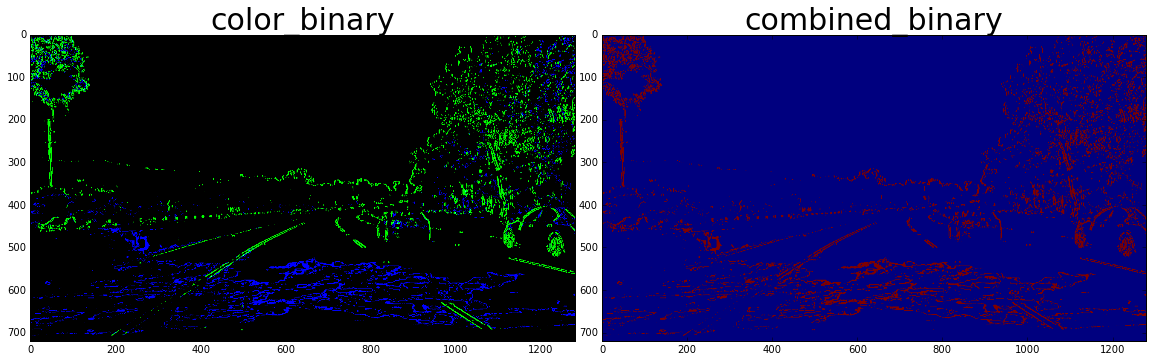

In [31]:
color_binary, combined_binary = thresholded_binary(undistorted)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(color_binary)
ax1.set_title('color_binary', fontsize=30)
ax2.imshow(combined_binary)
ax2.set_title('combined_binary', fontsize=30)
plt.show()

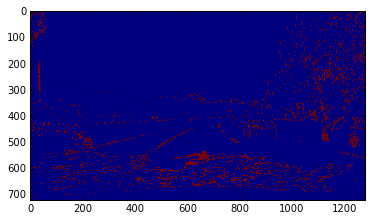

In [60]:
plt.imshow(combined_binary)
plt.show()

In [77]:
src = np.array([[[575+50, 464+50],
                 [730-50, 464+50],
                 [1100-100, 682],
                 [280+100, 682]]], dtype=np.int32 )
print(src)
type(src)

[[[ 625  514]
  [ 680  514]
  [1000  682]
  [ 380  682]]]


numpy.ndarray

In [78]:
mask = np.ones_like(img)
mask.shape

(720, 1280, 3)

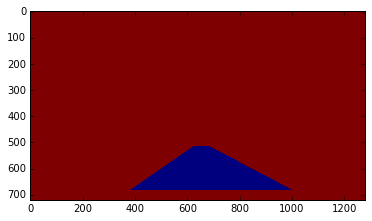

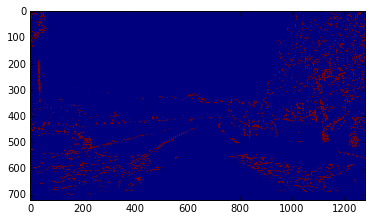

In [79]:
# the shadow of trees (thresholded in blue color using HLS-S channel)
# apply a mask to fillter out pixels inside the polygon


mask = np.ones_like(combined_binary)
cv2.fillPoly(mask, src, 0)
plt.imshow(mask)
plt.show()

masked_image = cv2.bitwise_and(combined_binary, mask)
plt.imshow(masked_image)
plt.show()

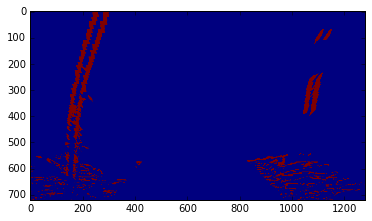

In [80]:
src, dst = get_src_dest_warp_img(img)
binary_warped, _, Minv = warp_image(masked_image, src, dst)
plt.imshow(binary_warped)
plt.show()

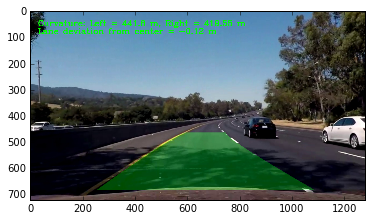

In [81]:
left_fitx, right_fitx, ploty, l, r, d = find_lane_lines(binary_warped)
lane_lines_img = draw_lanes_on_image(binary_warped, undistorted, Minv, left_fitx, right_fitx, ploty, l, r, d)
plt.imshow(lane_lines_img)
plt.show()

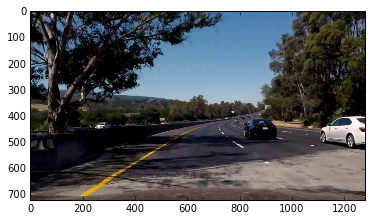

In [142]:
## debug
# Run on a test image 

test_image = "frame_001038.jpg"
old_image = "problem_output_imgs3/"+test_image
img = cv2.imread("problem_imgs/" + test_image)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
undistorted = undistort_image(img)
plt.imshow(undistorted)
plt.show()

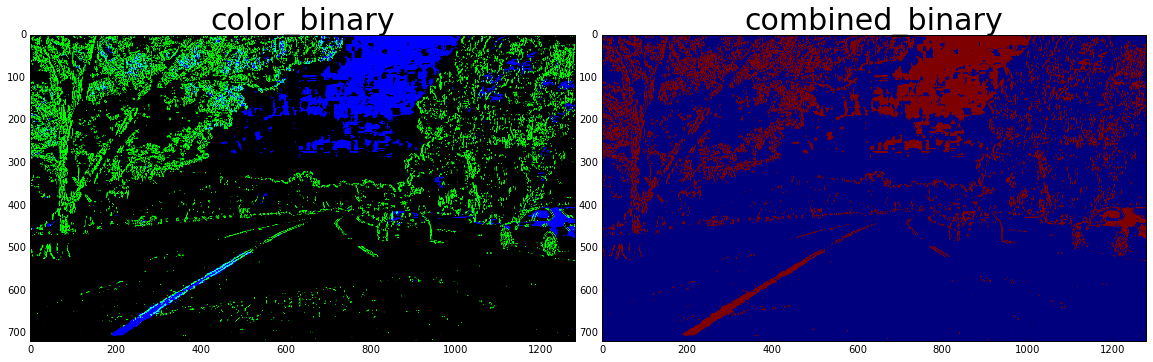

In [143]:
color_binary, combined_binary = thresholded_binary(undistorted)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(color_binary)
ax1.set_title('color_binary', fontsize=30)
ax2.imshow(combined_binary)
ax2.set_title('combined_binary', fontsize=30)
plt.show()

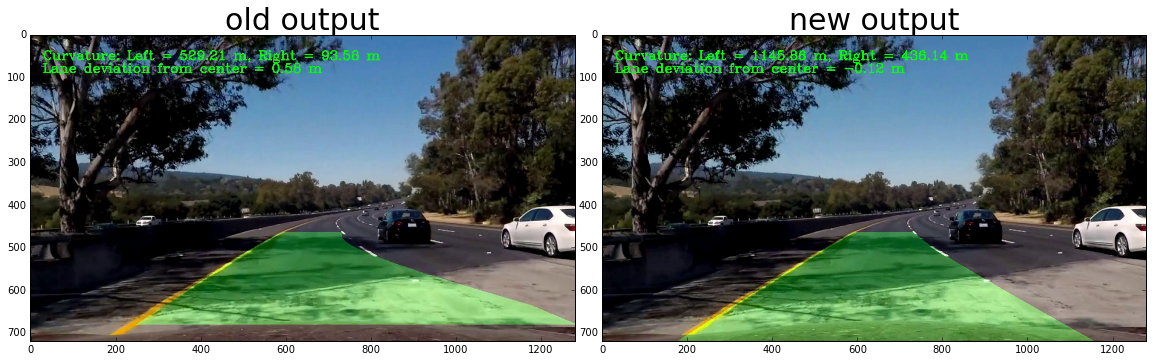

True

In [144]:
src, dst = get_src_dest_warp_img(img)
binary_warped, _, Minv = warp_image(combined_binary, src, dst)
left_fitx, right_fitx, ploty, l, r, d = find_lane_lines(binary_warped)
lane_lines_img = draw_lanes_on_image(binary_warped, undistorted, Minv, left_fitx, right_fitx, ploty, l, r, d)
old_img = cv2.cvtColor(cv2.imread(old_image), cv2.COLOR_BGR2RGB)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(old_img)
ax1.set_title('old output', fontsize=30)
ax2.imshow(lane_lines_img)
ax2.set_title('new output', fontsize=30)
plt.show()
lane_lines_img = cv2.cvtColor(lane_lines_img, cv2.COLOR_RGB2BGR)
cv2.imwrite('problem_output_imgs/correct_'+ test_image, lane_lines_img)


In [97]:
lane_lines_img = cv2.cvtColor(lane_lines_img, cv2.COLOR_BGR2RGB)

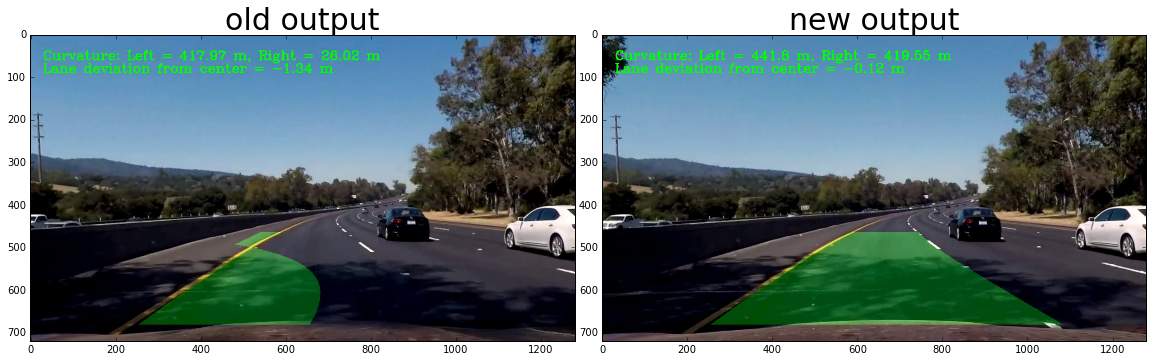

In [100]:
img1049_old = cv2.imread('problem_output_imgs/frame_001049.jpg')
img1049_old = cv2.cvtColor(img1049_old, cv2.COLOR_BGR2RGB)
img1049 = cv2.imread('problem_output_imgs/correct_frame_001049.jpg')
img1049 = cv2.cvtColor(img1049, cv2.COLOR_BGR2RGB)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(img1049_old)
ax1.set_title('old output', fontsize=30)
ax2.imshow(lane_lines_img)
ax2.set_title('new output', fontsize=30)
plt.show()

In [104]:
## debug
# Run on a test image
img = cv2.imread("~/Desktop/imgs/frame_001036.jpg")
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
undistorted = undistort_image(img)
plt.imshow(undistorted)
plt.show()

error: /home/travis/miniconda/conda-bld/conda_1485299292920/work/opencv-3.2.0/modules/imgproc/src/undistort.cpp:193: error: (-215) dst.data != src.data in function undistort
